Here we I will show how to analyse the primordial feature chains

# Importing libraries

In [1]:
from re import X
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import emcee, os
import h5py as h5
import json, sys
from tqdm import tqdm
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.integrate import quad
import getdist
from typing import List, Dict, Any, Optional, Callable
from scipy.stats import gaussian_kde

The main object we will be using to analyse the chains is the posterior binned along the frequency axis. I will start specifying a few parameters:

In [2]:
#binning parameters
BinningSpecs ={
    "A_min":-1,
    "A_max":1,
    "A_bin":0.001,
    "A_abs_bin":0.005
   }

#Settings for getdist
settings_getdist = {
'ignore_rows':0,
'fine_bins':2000,
'fine_bins_2D':2000, 
'smooth_scale_1D':0.1
}

In [3]:
#Storaging the binning specs for A
A_min = BinningSpecs["A_min"]
A_max = BinningSpecs ["A_max"]
A_bin = BinningSpecs["A_bin"]
A_array = np.arange(A_min, A_max + A_bin, A_bin)
A_ctrs = 0.5*(A_array[1:]+A_array[:-1])

#We will also be interested in working with the absolute value of the amplitude
A_abs_bin = BinningSpecs["A_abs_bin"]
A_abs_min = 0
A_abs_max = np.max([abs(A_max),abs(A_min)])
A_abs_array = np.arange(A_abs_min, A_abs_max + A_abs_bin, A_abs_bin)
A_abs_ctrs = 0.5*(A_abs_array[1:]+A_abs_array[:-1])

In [4]:
def read_chain(file_name: str, burnin_frac: float, thin: int) -> (np.ndarray, np.ndarray):
    """
    Read an MCMC chain from an HDF5 file, applying burn-in and thinning.

    Args:
        file_name (str): The name of the HDF5 file containing the MCMC chain.
        burnin_frac (float): The fraction of the initial part of the chain to discard as burn-in.
        thin (int): The thinning factor to apply to the chain.

    Returns:
        np.ndarray: The MCMC chain after applying burn-in and thinning.
        np.ndarray: The log-probabilities corresponding to the chain.
    """
    backend = emcee.backends.HDFBackend(file_name, read_only=True)
    chain = backend.get_chain(flat=False)
    chain_size = chain.shape[0]
    burnin = int(burnin_frac * chain_size)
    logprob = backend.get_log_prob(flat=True, discard=burnin, thin=thin)
    chain = backend.get_chain(flat=True, discard=burnin, thin=thin)
    return chain, logprob

def get_total_chain(handle: str, n: int, burnin_frac: float, thin: int, dir: Optional[str] = None) -> (np.ndarray, np.ndarray):
    """
    Retrieve and combine MCMC chains from HDF5 files.

    Args:
        handle (str): The base name of the HDF5 files containing the MCMC chains.
        n (int): The number of chains to combine. If n is 0, reads a single chain.
        burnin_frac (float): The fraction of the initial part of the chain to discard as burn-in.
        thin (int): The thinning factor to apply to the chain.
        dir (str, optional): An optional subdirectory within the chains directory where the HDF5 files are located.

    Returns:
        np.ndarray: The combined MCMC chain after applying burn-in and thinning.
        np.ndarray: The combined log-probabilities corresponding to the chain.
    """
    final_dir = 'chains/'

    if n == 0:
        file_name = os.path.join(final_dir, f"{handle}.h5")
        print(file_name)
        final_chain, final_logprob = read_chain(file_name, burnin_frac, thin)
    else:
        final_chain, final_logprob = None, None
        for i in range(n):
            file_name = os.path.join(final_dir, f"{handle}Run_{i}.h5")
            print(file_name)
            chain, logprob = read_chain(file_name, burnin_frac, thin)
            if final_chain is None:
                final_chain, final_logprob = chain, logprob
            else:
                final_chain = np.vstack((final_chain, chain))
                final_logprob = np.hstack((final_logprob, logprob))
    return final_chain, final_logprob

In [6]:
chain = get_total_chain('PrimFeature_lin_tutorial',0,0.5,10)

chains/PrimFeature_lin_tutorial.h5


Let us take a look at the posterior for a specific freq. range:

In [15]:
#Define the freq. range
omega_min = 305
omega_max = 315


#Get the samples inside the range
mask = (chain[0].T[3]>omega_min)&((chain[0].T[3]<omega_max))
masked_chain = chain[0][mask]
A_inbin = masked_chain.T[2]

#Use a kde to get a smooth pdf
pdf_smooth = gaussian_kde(A_inbin)

#Make a histogram to compare with the smooth result
pdf, _ = np.histogram(A_inbin, bins = A_array, density = True)

Text(0.5, 1.0, '$\\omega_{\\rm lin \\in [305, 315]}$')

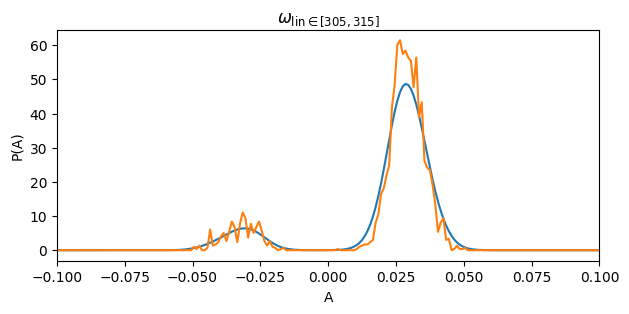

In [24]:
plt.figure(figsize = (7,3))
plt.plot(A_ctrs,pdf_smooth(A_ctrs))
plt.plot(A_ctrs,pdf)
plt.xlim(-0.1,0.1)
plt.xlabel('A')
plt.ylabel('P(A)')
plt.title(r'$\omega_{\rm lin \in [305, 315]}$')

In [26]:
for i in range(0, n_it-1):
        new_abs_step = i*A_abs_bin
        
        #Get the integration ranges
        range_int1 = [-new_abs_step, -previous_step]
        range_int2 = [previous_step, new_abs_step]

        #Perform the integral in each range and sum them
        try:
            int1 = quad(posterior,range_int1[0], range_int1[1])[0]/norm
            int2 = quad(posterior,range_int2[0], range_int2[1])[0]/norm
        except:
            print("Problem with integration range when computing the CDF!")            
            print(range_int1)
            sys.exit(-1)
        cumsum += int1 + int2
        
        #Storage the CDF for this step
        CDF_result.append(cumsum)
        
        #Storage the A value for this step
        A_axis.append(0.5*(previous_step+new_abs_step))
        previous_step = new_abs_step

    inv_CDF_interped = interp1d(CDF_result, A_axis)
    if isinstance(threshold, list):
        output = []
        for x in threshold:
            try:
                output.append(inv_CDF_interped(x))
            except:
                print("Error saturated the maximum allowed value!")
                output.append(A_abs_max)
        return output
    else:
        return inv_CDF_interped(threshold)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 25)

In [ ]:
#What burnin to apply
burnin = 0.2

#thinning the chain
thin = 1

#chain file
chain_filename = 'PrimFeature_lin_tutorial'

#what frequency range to analyse
omega_min = 100
omega_max = 400
omega_bin = 15
#Mapping the params to the indices in the chain
params_map = {
    "alpha":1,
    "A":2,
    "phi":4,
    "omega":3,
    "BNGC":0,
}

In [ ]:
results = binned_posterior(chain_filename, burnin, 0, omega_min, omega_max, omega_bin, params_map, thin)

In [ ]:
results.keys()

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,3))

ax[0].plot(results['omega_ctrs'],results['A_mean'])
ax[0].set_ylabel(r'$A_{\rm lin}$')
ax[0].set_xlabel(r'$\omega_{\rm lin}$')

ax[1].plot(results['omega_ctrs'],results['A_1sigma'])
ax[1].set_ylabel(r'$A_{\rm lin}$')
ax[1].set_xlabel(r'$\omega_{\rm lin}$')